In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.python.framework import ops

%matplotlib inline
plt.rcParams['figure.figsize'] = [16, 9]
plt.style.use('ggplot')

In [2]:
DATA_PATH = '../data/'

In [3]:
def read(filepath, pred=False):
    dat = pd.read_csv(filepath)
    if not pred:
        dat['buyDate'] = pd.to_datetime(dat['buyDate'])
        dat['sellDate'] = pd.to_datetime(dat['sellDate'])
    return dat

In [4]:
dat = read(DATA_PATH + 'buyStats.csv')
new_dat = read(DATA_PATH + 'Multistock.csv', pred=True)
dat.head()

,stock,bundles,buyPrice,sellPrice,change,buyDate,sellDate,nDays,d30Sell,d30Gains,...,ohCheap,ohOut,RSI14,stockMACD,spVal,macd,spRSI14,spPmoB75_40_20,spPmoW75_40_20,vix
0,cgnx,2,NaN,NaN,NaN,2017-07-03,NaT,-2,NaN,NaN,...,NaN,NaN,35.25,-3.148,2423,-8.678,49.36,0.581,0.610,11.18
1,cgnx,2,90.10,NaN,NaN,2017-06-29,NaT,2,NaN,NaN,...,1.0,2.50,46.90,-1.911,2441,-4.685,57.26,0.607,0.615,10.03
2,nvda,2,NaN,NaN,NaN,2017-07-03,NaT,-2,NaN,NaN,...,NaN,NaN,47.78,-3.507,2423,-8.678,49.36,0.581,0.610,11.18
3,nvda,2,151.52,NaN,NaN,2017-06-14,NaT,17,NaN,NaN,...,1.0,2.34,66.86,4.564,2440,4.950,66.39,0.630,0.600,10.42
4,tsco,2,NaN,NaN,NaN,2017-07-03,NaT,-2,NaN,NaN,...,NaN,NaN,44.29,0.113,2423,-8.678,49.36,0.581,0.610,11.18


In [5]:
def drop_missing(dfs, y_col):
    X = dfs[0].copy()
    # cols
    drop_cols = [col for col in list(X) if type(col[0]) == np.float and col.isnan().all()]
    X = X.drop(drop_cols, axis=1)
    X2 = dfs[1].drop(drop_cols, axis=1)
    return X.loc[np.isnan(dat[y_col]) == False, :], X2

In [6]:
dat, new_dat = drop_missing([dat, new_dat], 'd30Gains')
dat.head()

,stock,bundles,buyPrice,sellPrice,change,buyDate,sellDate,nDays,d30Sell,d30Gains,...,ohCheap,ohOut,RSI14,stockMACD,spVal,macd,spRSI14,spPmoB75_40_20,spPmoW75_40_20,vix
14,odfl,1,86.87,NaN,NaN,2017-05-22,NaT,40,93.02,1.07080,...,2.67,2.38,52.25,-0.496,2382,-8.638,NaN,NaN,NaN,12.04
21,adbe,0,131.72,143.35,1.088293,2017-04-21,2017-06-06,71,136.43,1.03576,...,1.33,1.72,75.22,-0.066,2349,-11.600,NaN,NaN,NaN,14.20
22,ahgp,0,29.10,NaN,NaN,2017-05-22,NaT,40,23.95,0.82302,...,3.67,3.00,55.97,0.202,2382,-8.638,NaN,NaN,NaN,12.04
24,amrc,0,6.60,NaN,NaN,2017-05-12,NaT,50,6.85,1.03788,...,3.33,1.33,56.26,0.107,2394,4.011,NaN,NaN,NaN,10.60
25,atvi,0,53.30,57.06,1.070544,2017-05-02,2017-06-12,60,59.56,1.11745,...,2.33,1.77,79.02,0.629,2388,5.301,NaN,NaN,NaN,10.11


In [7]:
new_dat.head()

,stock,bundles,MF,MFRisk,n_L52,n_H52,pE,pB,revG5,freeCashFlow,...,ohCheap,ohOut,RSI14,stockMACD,spVal,macd,spRSI14,spPmoB75_40_20,spPmoW75_40_20,vix
0,AAPL,1,start,5.0,1.526121,0.919374,50.0,96.0,86.0,100.0,...,3.00,1.98,41.35,-2.932,2423.41,-8.678,49.36,0.581,0.61,11.18
1,ODFL,1,none,8.0,1.599328,0.987352,54.0,78.0,84.0,69.0,...,2.33,2.31,64.14,0.482,2423.41,-8.678,49.36,0.581,0.61,11.18
2,NVDA,2,now,8.0,3.140561,0.857923,82.0,95.0,77.0,94.0,...,1.00,2.32,47.78,-3.507,2423.41,-8.678,49.36,0.581,0.61,11.18
3,CGNX,2,now,8.0,2.024803,0.866415,76.0,95.0,79.0,87.0,...,1.00,2.50,35.25,-3.148,2423.41,-8.678,49.36,0.581,0.61,11.18
4,ALGN,1,none,NaN,1.869489,0.969454,73.0,89.0,73.0,90.0,...,1.33,1.54,57.29,-0.697,2423.41,-8.678,49.36,0.581,0.61,11.18


In [8]:
def split_xy(df, y_col, first_X):
    y = df[y_col]
    start_col = list(df).index(first_X)
    X = df.iloc[:, start_col:]
    return X, y

In [9]:
X, y = split_xy(dat, 'd30Gains', 'MF')
X_new = new_dat.iloc[:, 2:]
stocks = new_dat['stock']
X.head()

,MF,MFRisk,n_L52,n_H52,pE,pB,revG5,freeCashFlow,grossMarQ,opMarQ,...,ohCheap,ohOut,RSI14,stockMACD,spVal,macd,spRSI14,spPmoB75_40_20,spPmoW75_40_20,vix
14,now,8.0,1.515509,0.905444,64.0,77.0,84.0,NaN,NaN,78.0,...,2.67,2.38,52.25,-0.496,2382,-8.638,NaN,NaN,NaN,12.04
21,now,9.0,1.457900,0.998000,NaN,NaN,NaN,NaN,NaN,NaN,...,1.33,1.72,75.22,-0.066,2349,-11.600,NaN,NaN,NaN,14.20
22,none,NaN,1.808750,0.885015,21.0,73.0,61.0,96.0,NaN,81.0,...,3.67,3.00,55.97,0.202,2382,-8.638,NaN,NaN,NaN,12.04
24,none,NaN,1.580189,0.950355,NaN,NaN,NaN,NaN,NaN,NaN,...,3.33,1.33,56.26,0.107,2394,4.011,NaN,NaN,NaN,10.60
25,start,9.0,1.570790,0.993777,56.0,45.0,43.0,98.0,NaN,94.0,...,2.33,1.77,79.02,0.629,2388,5.301,NaN,NaN,NaN,10.11


In [10]:
print(list(X) == list(X_new))
#[(x, xn) for (x, xn) in zip(list(X), list(X_new))]

True


In [11]:
def one_hot(df):
    X = df.copy()
    X[['mfNone', 'mfNow', 'mfStart']] = pd.get_dummies(X['MF'])
    X = X.drop('MF', axis=1)
    return X

In [12]:
X = one_hot(X)
X_new = one_hot(X_new)
X.head()

,MFRisk,n_L52,n_H52,pE,pB,revG5,freeCashFlow,grossMarQ,opMarQ,roaTTM,...,stockMACD,spVal,macd,spRSI14,spPmoB75_40_20,spPmoW75_40_20,vix,mfNone,mfNow,mfStart
14,8.0,1.515509,0.905444,64.0,77.0,84.0,NaN,NaN,78.0,NaN,...,-0.496,2382,-8.638,NaN,NaN,NaN,12.04,0,1,0
21,9.0,1.457900,0.998000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.066,2349,-11.600,NaN,NaN,NaN,14.20,0,1,0
22,NaN,1.808750,0.885015,21.0,73.0,61.0,96.0,NaN,81.0,NaN,...,0.202,2382,-8.638,NaN,NaN,NaN,12.04,1,0,0
24,NaN,1.580189,0.950355,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.107,2394,4.011,NaN,NaN,NaN,10.60,1,0,0
25,9.0,1.570790,0.993777,56.0,45.0,43.0,98.0,NaN,94.0,NaN,...,0.629,2388,5.301,NaN,NaN,NaN,10.11,0,0,1


In [13]:
def median_fill(df):
    X = df.copy()

    for col in list(X):
        try:
            X[col][np.isnan(X[col])] = np.nanmedian(X[col])
        except:
            print('Could not fill column', col)
    return X

In [14]:
# ONLY DO UNTIL DATA EXIST!
X.head()
X = X.drop('grossMarQ', axis=1)
X_new = X_new.drop('grossMarQ', axis=1)

In [15]:
X = median_fill(X)
X_new = median_fill(X_new)

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [16]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=11235)
# Reindex
X_train.index = range(len(y_train))
y_train.index = range(len(y_train))

In [17]:
print(X_train.shape)
print(X_test.shape)
print(X_new.shape)

print(list(X) == list(X_new))
#[(x, xn) for (x, xn) in zip(list(X), list(X_new))]

(30, 27)
(8, 27)
(17, 27)
True


In [19]:
# WHILE DATA SET IS SMALL, restrict values in new data to the range seen in training data
for col in list(X_train):
    mn, mx = np.min(X_train[col]), np.max(X_train[col])
    X_new[col][X_new[col] < mn] = mn
    X_new[col][X_new[col] > mx] = mx

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [20]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_new  = scaler.transform(X_new)

## Create Neural Net

In [22]:
# Create a fully-connected layer of neurons using dropout regularization
def make_drop_layer(in_layer,
                    n_out,
                    activation,
                    kernel_initializer,
                    dropout_rate,
                    training):
    h = tf.layers.dense(in_layer,
                        n_out,
                        activation=activation,
                        kernel_initializer=kernel_initializer)
    h_drop = tf.layers.dropout(h, rate=dropout_rate, training=training)
    return h_drop

In [45]:
ops.reset_default_graph()
g = tf.get_default_graph()
[op.name for op in g.get_operations()]

[]

In [137]:
N, D = X_train.shape
DROPOUT_RATE = 0.0
ETA = 0.003 # Learning rate

X = tf.placeholder(tf.float32, shape=[None, D], name='X')
y = tf.placeholder(tf.float32, shape=None, name='y')
training = tf.placeholder_with_default(False, shape=(), name='training')

X_drop = tf.layers.dropout(X, DROPOUT_RATE, training=training)
n_neurons = [D, 27, 20, 20, 20, 20, 1]

In [138]:
with tf.name_scope('dnn'):
    # He intialization randomly initalizes weigths and their variances in 
    # a way that minimizes the likelihood of vanishing/exploding gradients
    he_init = tf.contrib.layers.variance_scaling_initializer()
    current_in = X

    for layer in range(1, len(n_neurons)):
        current_in = make_drop_layer(
            in_layer=current_in,
            n_out=n_neurons[layer],
            activation=tf.nn.tanh if (layer + 1) < len(n_neurons) else None,
            kernel_initializer=he_init,
            dropout_rate=DROPOUT_RATE,
            training=training)

    preds = tf.nn.relu(current_in)

In [139]:
with tf.name_scope('cost'):
    # MSE
    cost = tf.reduce_sum(tf.pow(preds - y, 2))/(2 * N)

In [140]:
with tf.name_scope('train'):
    eta0 = ETA # initial learning rate
    decay_steps = 100  # eta updates after this many epochs
    decay_rate = 0.99    # factor to change eta by
    global_step = tf.Variable(0, trainable=False, name='global_step')
    eta = tf.train.exponential_decay(
        eta0, global_step, decay_steps, decay_rate, name='eta')
    optimizer = tf.train.AdamOptimizer(eta).minimize(
        cost, global_step=global_step)

In [141]:
epochs = 4000
batch_size = 7
train_err = []
test_err = []
saver = tf.train.Saver()

In [142]:
print(X_train.shape)
print(y_train.shape)

(30, 27)
(30,)


In [143]:
with tf.Session() as s:
    s.run(tf.global_variables_initializer())

    for epoch in range(epochs):
        idxs = np.random.permutation(range(N))
        n_batches = len(idxs) // batch_size

        for batch in range(n_batches):
            idx = idxs[batch * batch_size : (batch + 1) * batch_size]
            s.run(optimizer, feed_dict={training: True,
                                        X: X_train[idx, :],
                                        y: y_train[idx]})
        err_train = cost.eval(feed_dict={X: X_train[idx, :],
                                         y: y_train[idx]})
        err_test = cost.eval(feed_dict={X: X_test, y: y_test}) * (N) / (len(y_test))

        train_err.append(err_train)
        test_err.append(err_test)

        if epoch % 100 == 0:
            print(
                '%4d: Train error: %.5f\tTest error: %.9f'
                %(epoch, err_train, err_test))

    save_path = saver.save(s, './nn_mod.ckpt')

   0: Train error: 0.77602	Test error: 1.350900605
 100: Train error: 0.00233	Test error: 0.301519101
 200: Train error: 0.01370	Test error: 0.158130624
 300: Train error: 0.00796	Test error: 0.131402104
 400: Train error: 0.00669	Test error: 0.077845689
 500: Train error: 0.00126	Test error: 0.068891714
 600: Train error: 0.01451	Test error: 0.052132270
 700: Train error: 0.00746	Test error: 0.040692502
 800: Train error: 0.00516	Test error: 0.040699990
 900: Train error: 0.00426	Test error: 0.026057900
1000: Train error: 0.00731	Test error: 0.036539070
1100: Train error: 0.00163	Test error: 0.029711217
1200: Train error: 0.00794	Test error: 0.017907709
1300: Train error: 0.00874	Test error: 0.030835663
1400: Train error: 0.00800	Test error: 0.041482985
1500: Train error: 0.00570	Test error: 0.024552339
1600: Train error: 0.00676	Test error: 0.025364652
1700: Train error: 0.00928	Test error: 0.012602246
1800: Train error: 0.00554	Test error: 0.016938602
1900: Train error: 0.00592	Test

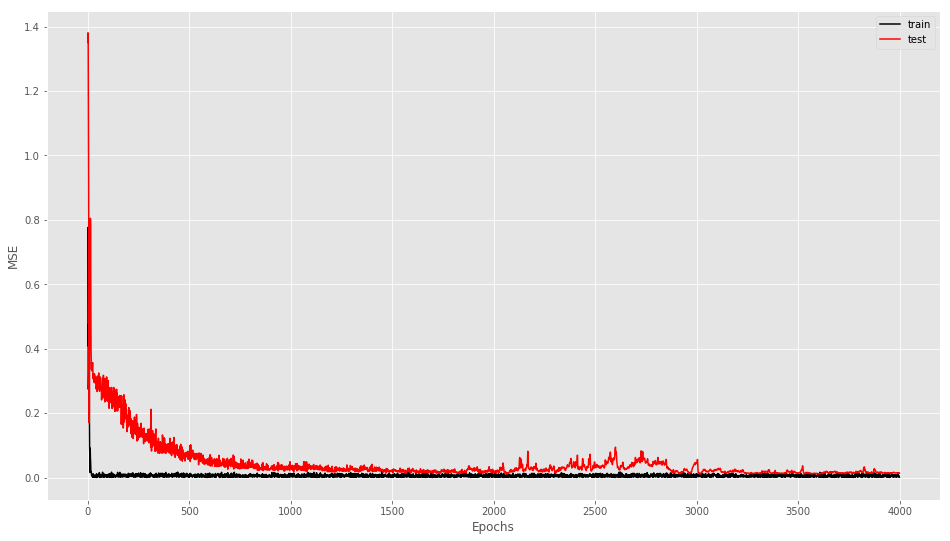

In [144]:
plt.plot(train_err, 'k-', label='train');
plt.plot(test_err, 'r-', label='test');
plt.legend(loc='best');
plt.xlabel('Epochs');
plt.ylabel('MSE');

In [145]:
s = tf.Session()
saver = tf.train.Saver()
saver.restore(s, './nn_mod.ckpt')
new_preds = s.run(preds, feed_dict={X: X_new})
#new_preds = s.run(preds, feed_dict={X: X_test})

In [146]:
final_out = []
for stock, pred in zip(stocks, new_preds.reshape(new_preds.shape[0])):
    final_out.append([stock, pred])
    
out = pd.DataFrame(columns=['Stock', 'Prediction'], data=final_out)
out = out.sort_values('Prediction', ascending=False)
out.head(len(stocks))

,Stock,Prediction
10,ELLI,1.010810
1,ODFL,0.996445
16,ELIO,0.971508
12,KMI,0.959250
15,SWIR,0.950942
0,AAPL,0.947441
11,TXT,0.843271
6,ILMN,0.841459
2,NVDA,0.832278
9,TSCO,0.733706
